### Descriptive and comparative analysis of IgA measures

This notebook explores different strategies to compare IgA measures using different categorical values for Attachment and Gender.

Specifically, this notebook implements:

- Reading and cleaning input data
- Remove non-relevant columns
- Plot distributions of IgA by Attachment and Gender using boxplots and violin plots
- Statistical comparison for IgA measures by U-test and kruskal with Dunn test
- Estimating Cliffs for detecting differences between distributions
- Estimating Rank biserial
- Exploring clustering strategies for pattern generation

- Handling modules

In [80]:
import warnings
warnings.filterwarnings("ignore")

- Loading modules

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
from scipy.stats import kruskal
from typing import Tuple
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler

- Auxiliar functions

In [82]:
def classify_iga_level(avg):
    if avg > 100:
        return "High sIgA"
    elif avg < 30:
        return "Low sIgA"
    else:
        return "Moderate sIgA"

In [83]:
def rank_biserial_correlation(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute rank-biserial correlation from two independent samples.
    """
    from scipy.stats import mannwhitneyu

    nx = len(x)
    ny = len(y)

    U, _ = mannwhitneyu(x, y, alternative='two-sided')
    rbc = 1 - (2 * U) / (nx * ny)

    abs_rbc = abs(rbc)
    if abs_rbc < 0.1:
        interpretation = "Negligible"
    elif abs_rbc < 0.3:
        interpretation = "Small"
    elif abs_rbc < 0.5:
        interpretation = "Medium"
    else:
        interpretation = "Large"

    return rbc, interpretation

In [84]:
def cliffs_delta(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute Cliff's Delta and return interpretation.
    """
    nx = len(x)
    ny = len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (greater - less) / (nx * ny)

    abs_delta = abs(delta)
    if abs_delta < 0.147:
        interpretation = "Negligible"
    elif abs_delta < 0.33:
        interpretation = "Small"
    elif abs_delta < 0.474:
        interpretation = "Medium"
    else:
        interpretation = "Large"
    return delta, interpretation

-Loading data

In [85]:
df_data = pd.read_csv("../processed_data/1_processed_data_IgA.csv")
df_data.head(5)

,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,11,Male,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure


In [86]:
df_data.columns

Index(['ID', 'Gender', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment'],
      dtype='object')

In [87]:
df_data["Attachment"].value_counts()

Attachment
Secure      21
Insecure    14
Name: count, dtype: int64

- Data visualization

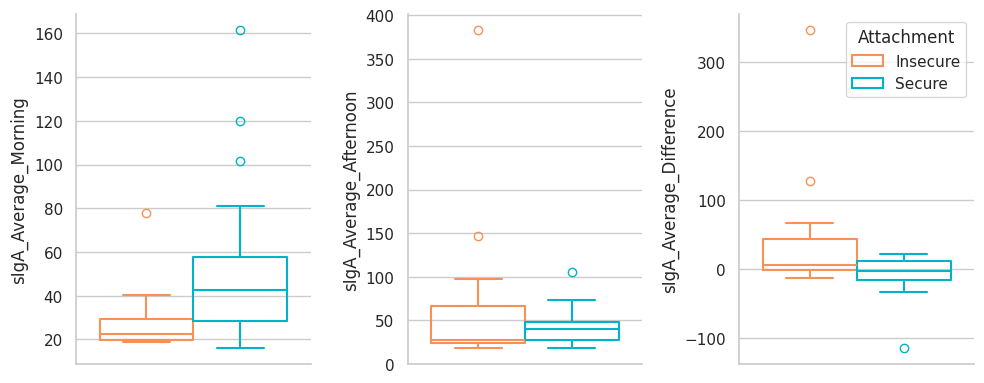

In [88]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Morning", 
    hue="Attachment", 
    ax=axes[0], 
    fill=False,
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Afternoon", 
    hue="Attachment", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Difference", 
    hue="Attachment", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

- U-test and Kruskal comparison

In [89]:
iga_vars = ["sIgA_Average_Morning", "sIgA_Average_Afternoon", 
            "sIgA_Average_Difference"]

In [90]:
attachment_results = []
for var in iga_vars:
    secure_vals = df_data[df_data["Attachment"] == "Secure"][var]
    insecure_vals = df_data[df_data["Attachment"] == "Insecure"][var]
    stat, p = mannwhitneyu(secure_vals, insecure_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    attachment_results.append(statistic_result)

attachment_results = pd.DataFrame(attachment_results)
attachment_results["reject"] = attachment_results["p-value"]<=0.05
attachment_results

,variable,U statistic,p-value,reject
0,sIgA_Average_Morning,220.0,0.014638,True
1,sIgA_Average_Afternoon,162.0,0.625380,False
2,sIgA_Average_Difference,83.0,0.032504,True


- Cliffs estimation

In [91]:
attachment_cliffs = []
for var in iga_vars:
    secure = df_data[df_data["Attachment"] == "Secure"][var]
    insecure = df_data[df_data["Attachment"] == "Insecure"][var]
    delta, interp = cliffs_delta(insecure, secure)
    attachment_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

attachment_cliffs = pd.DataFrame(attachment_cliffs)
attachment_cliffs

,variable,Cliff's Delta,Interpretation
0,sIgA_Average_Morning,-0.496599,Large
1,sIgA_Average_Afternoon,-0.102041,Negligible
2,sIgA_Average_Difference,0.435374,Medium


- RBC estimation 

In [92]:
rbc_attachment = []
for var in iga_vars:
    secure = df_data[df_data["Attachment"] == "Secure"][var]
    insecure = df_data[df_data["Attachment"] == "Insecure"][var]
    rbc, interp = rank_biserial_correlation(secure, insecure)
    rbc_attachment.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_attachment = pd.DataFrame(rbc_attachment)
rbc_attachment

,variable,Rank-Biserial Corr,Interpretation
0,sIgA_Average_Morning,-0.496599,Medium
1,sIgA_Average_Afternoon,-0.102041,Small
2,sIgA_Average_Difference,0.435374,Medium


- Merge comparisons

In [93]:
attachment_results.merge(right=attachment_cliffs, on="variable").merge(right=rbc_attachment, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,sIgA_Average_Morning,220.0,0.014638,True,-0.496599,Large,-0.496599,Medium
1,sIgA_Average_Afternoon,162.0,0.625380,False,-0.102041,Negligible,-0.102041,Small
2,sIgA_Average_Difference,83.0,0.032504,True,0.435374,Medium,0.435374,Medium


- Data visualization with multiple plots

- Working with clustering and pattern recognition for profile generation. Manually with the following ranges:

| Range  | Category        | Justification                                                                                                       |
| ------ | -------------------- | ------------------------------------------------------------------------------------------------------------------- |
| `> 50` | **High variability** | It represents a significant change in daily concentration (>50 µg/mL), beyond the typical circadian variation. |
| `≤ 50` | **Low/Moderate**     | Changes that could be physiological, within the range expected under normal conditions.                           |


| Range    | Category    | Justification                                                                                                         |
| -------- | ---------------- | --------------------------------------------------------------------------------------------------------------------- |
| `< 30`   | **Low IgA**      | Consistently low values ​​in the sample possibly reflect immune suppression or specific conditions. |
| `30–100` | **Moderate IgA** | Central range of most subjects.                                                                           |
| `> 100`  | **High IgA**     | Less frequent elevated values ​​that could be biologically or clinically significant.                     |


In [94]:
df_data["Variability_Profile"] = df_data["sIgA_Average_Difference"].apply(
    lambda x: "High variability" if x > 50 else "Low/Moderate"
)

df_data["sIgA_Level_Profile_Morning"] = df_data["sIgA_Average_Morning"].apply(classify_iga_level)
df_data["sIgA_Level_Profile_Afternoon"] = df_data["sIgA_Average_Afternoon"].apply(classify_iga_level)
df_data.head(5)


,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,Variability_Profile,sIgA_Level_Profile_Morning,sIgA_Level_Profile_Afternoon
0,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,Low/Moderate,Low sIgA,Low sIgA
1,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure,Low/Moderate,Low sIgA,Moderate sIgA
2,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,Low/Moderate,High sIgA,Moderate sIgA
3,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,Low/Moderate,Low sIgA,Moderate sIgA
4,11,Male,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure,High variability,Moderate sIgA,High sIgA


In [95]:
df_data["Variability_Profile"].value_counts()

Variability_Profile
Low/Moderate        31
High variability     4
Name: count, dtype: int64

In [96]:
df_data["sIgA_Level_Profile_Morning"].value_counts()

sIgA_Level_Profile_Morning
Low sIgA         18
Moderate sIgA    14
High sIgA         3
Name: count, dtype: int64

In [97]:
df_data["sIgA_Level_Profile_Afternoon"].value_counts()

sIgA_Level_Profile_Afternoon
Low sIgA         16
Moderate sIgA    16
High sIgA         3
Name: count, dtype: int64

- Checking changes

In [98]:
changing_data = []
for index in df_data.index:
    change = ""
    morning = df_data["sIgA_Level_Profile_Morning"][index]
    afternoon = df_data["sIgA_Level_Profile_Afternoon"][index]

    if morning == afternoon:
        change = "No Change"
    elif (morning == "Low sIgA" and afternoon in ["Moderate sIgA", "High sIgA"]) or (morning == "Moderate sIgA" and afternoon == "High sIgA"):
        change = "Increase"
    elif (morning == "Moderate sIgA" and afternoon == "Low sIgA") or (morning == "High sIgA" and afternoon == "Moderate sIgA"):
        change = "Decrease"
    else:
        change = "check"
    
    changing_data.append(change)

df_data["sIgA-Change"] = changing_data
df_data["sIgA-Change"].value_counts()
    

sIgA-Change
No Change    22
Increase      7
Decrease      6
Name: count, dtype: int64

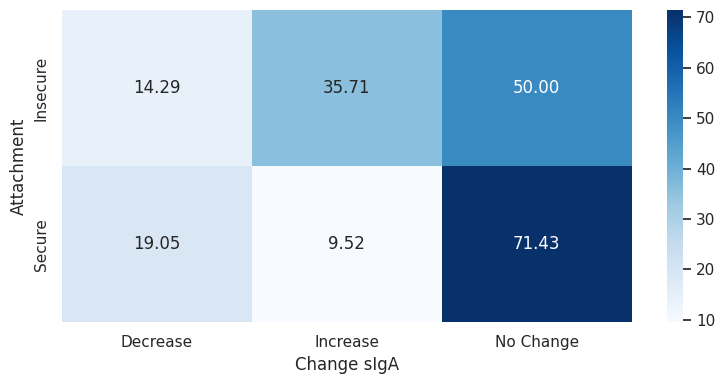

In [99]:
heat_data = pd.crosstab(df_data["Attachment"], df_data["sIgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Attachment")
plt.xlabel("Change sIgA")
plt.tight_layout()
plt.show()

### Additional analysis (1): PCA visualization and scatter plots

In [100]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [101]:
df_data.columns

Index(['ID', 'Gender', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment', 'Variability_Profile', 'sIgA_Level_Profile_Morning',
       'sIgA_Level_Profile_Afternoon', 'sIgA-Change'],
      dtype='object')

In [102]:
df_for_reductions = df_data[iga_vars]
df_for_reductions.head()

,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference
0,21.765240,28.368055,6.602815
1,28.473065,50.881961,22.408896
2,161.424693,46.867951,-114.556742
3,24.173487,35.942378,14.343241
4,78.013279,382.715268,345.590046


In [103]:
pca_instance = PCA()
pca_instance.fit(X=df_for_reductions.values)
header = [f"p_{i+1}" for i in range(pca_instance.n_components_)]
data_transformed = pd.DataFrame(
    data=pca_instance.transform(df_for_reductions.values),
    columns=header,
    index=df_data.index)
print(pca_instance.n_components_)
print(pca_instance.explained_variance_ratio_)
data_transformed.head(5)

3
[8.45888493e-01 1.53448346e-01 6.63160426e-04]


,p_1,p_2,p_3
0,-22.048852,-24.489125,-0.483245
1,5.008492,-16.241188,0.771640
2,-94.963863,146.416001,0.735943
3,-11.174119,-22.541833,-1.499330
4,468.643699,28.886255,-3.648843


In [104]:
data_transformed = pd.concat([data_transformed, df_data], axis=1)
data_transformed.head(5)

,p_1,p_2,p_3,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,Variability_Profile,sIgA_Level_Profile_Morning,sIgA_Level_Profile_Afternoon,sIgA-Change
0,-22.048852,-24.489125,-0.483245,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,Low/Moderate,Low sIgA,Low sIgA,No Change
1,5.008492,-16.241188,0.771640,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure,Low/Moderate,Low sIgA,Moderate sIgA,Increase
2,-94.963863,146.416001,0.735943,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,Low/Moderate,High sIgA,Moderate sIgA,Decrease
3,-11.174119,-22.541833,-1.499330,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,Low/Moderate,Low sIgA,Moderate sIgA,Increase
4,468.643699,28.886255,-3.648843,11,Male,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure,High variability,Moderate sIgA,High sIgA,Increase


In [105]:
tsne_instance = TSNE(n_components=2, perplexity=3)
header = ["p_1", "p_2"]
tsne_data_transformed = pd.DataFrame(
    data=tsne_instance.fit_transform(df_for_reductions.values),
    columns=header,
    index=df_data.index)
tsne_data_transformed.head(5)

,p_1,p_2
0,123.142159,30.795099
1,62.725975,53.829956
2,-81.129456,-4.428396
3,95.183128,48.016426
4,12.798004,105.258217


In [106]:
tsne_data_transformed = pd.concat([tsne_data_transformed, df_data], axis=1)
tsne_data_transformed.head(5)

,p_1,p_2,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,Variability_Profile,sIgA_Level_Profile_Morning,sIgA_Level_Profile_Afternoon,sIgA-Change
0,123.142159,30.795099,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,Low/Moderate,Low sIgA,Low sIgA,No Change
1,62.725975,53.829956,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure,Low/Moderate,Low sIgA,Moderate sIgA,Increase
2,-81.129456,-4.428396,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,Low/Moderate,High sIgA,Moderate sIgA,Decrease
3,95.183128,48.016426,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,Low/Moderate,Low sIgA,Moderate sIgA,Increase
4,12.798004,105.258217,11,Male,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure,High variability,Moderate sIgA,High sIgA,Increase


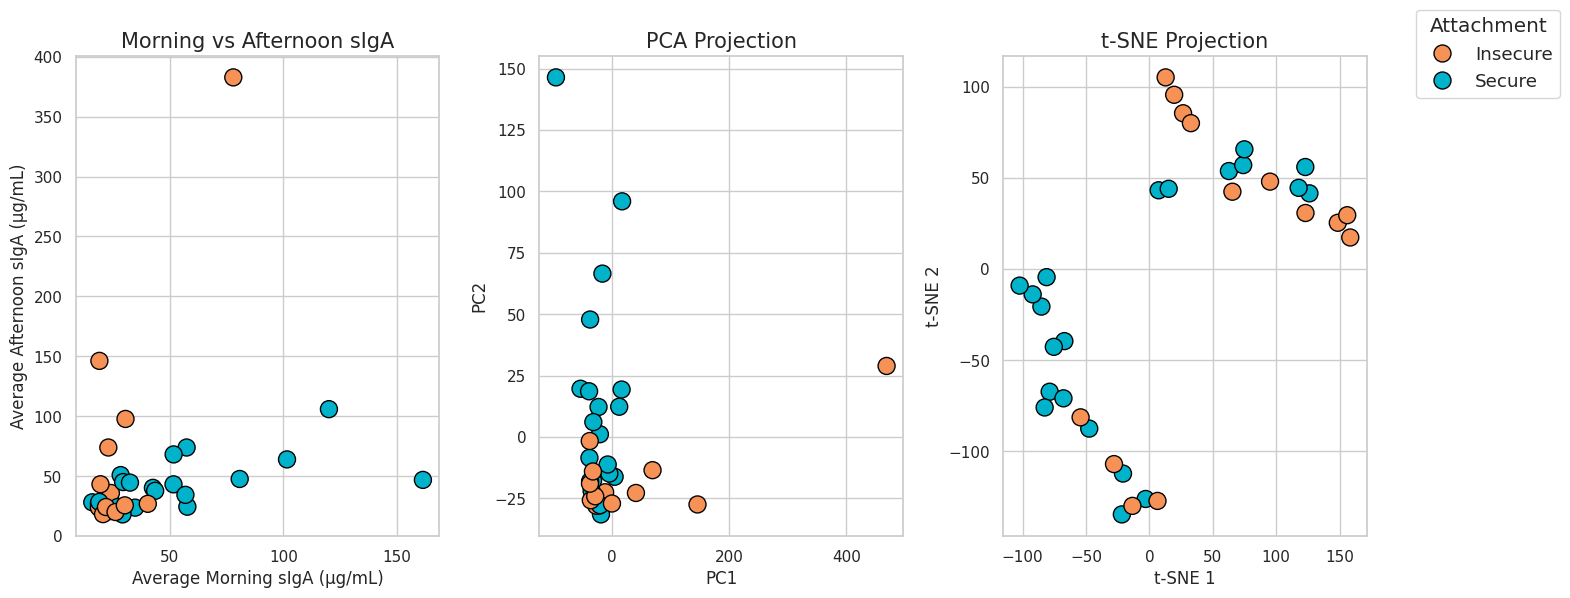

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=False)
sns.set(style="whitegrid", font_scale=1.2)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256", "Unknown": "#58E0B0"}

# Gráfico 1: Promedio IgA Mañana vs Tarde
sns.scatterplot(
    ax=axes[0],
    data=df_data,
    x="sIgA_Average_Morning",
    y="sIgA_Average_Afternoon",
    hue="Attachment",
    palette=palette,
    s=150,
    edgecolor="black",
)

axes[0].set_title("Morning vs Afternoon sIgA", fontsize=15)
axes[0].set_xlabel("Average Morning sIgA (µg/mL)")
axes[0].set_ylabel("Average Afternoon sIgA (µg/mL)")

# Gráfico 2: Proyección PCA
sns.scatterplot(
    ax=axes[1],
    data=data_transformed,
    x="p_1",
    y="p_2",
    hue="Attachment",
    palette=palette,
    s=150,
    edgecolor="black"
)

axes[1].set_title("PCA Projection", fontsize=15)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

# Gráfico 3: Proyección t-SNE
sns.scatterplot(
    ax=axes[2],
    data=tsne_data_transformed,
    x="p_1",
    y="p_2",
    hue="Attachment",
    palette=palette,
    s=150,
    edgecolor="black"
)
axes[2].set_title("t-SNE Projection", fontsize=15)
axes[2].set_xlabel("t-SNE 1")
axes[2].set_ylabel("t-SNE 2")

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, title="Attachment", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

for ax in axes:
    ax.get_legend().remove()

plt.tight_layout()

In [108]:
df_data.to_csv("../results_process/results_analysis_IgA_normal_data.csv", index=False)